In [10]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tabpfn import TabPFNClassifier
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [11]:
# df = pd.read_csv("../data/dataset.csv")

train = pd.read_csv("../data/dataset_years_train.csv")
val = pd.read_csv("../data/dataset_years_val.csv")
test  = pd.read_csv("../data/dataset_years_test.csv")

In [12]:
CAT_COLS = [
    "driver_id",
    "constructor_id",
    "circuit_id",
    "year",
    "round_number",
]
NUM_COLS = [
    "quali_delta",
    "quali_tm_delta",
    "season_pts_driver",
    "season_pts_team",
    "last_3_avg",
    "is_street_circuit",
    "is_wet",
]

TARGET = 'points_scored'

# ### RANDOM SPLIT
# X = df.drop(columns=[TARGET])
# y = df[TARGET]

# X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

# mappings = {}
# for col in CAT_COLS:
#     cats = X_train[col].astype("category").cat.categories
#     mapping = {v: i for i, v in enumerate(cats)}
#     mappings[col] = mapping

#     X_train[col] = X_train[col].map(mapping).astype("int64")
#     X_val[col] = X_val[col].map(mapping).fillna(-1).astype("int64")
#     X_test[col] = X_test[col].map(mapping).fillna(-1).astype("int64")

# ### YEAR SPLIT
# for col in CAT_COLS:
#     all_vals = pd.concat([train[col], val[col], test[col]], axis=0)
#     codes = all_vals.astype("category").cat.categories
#     mapping = {v: i for i, v in enumerate(codes)}
#     for df in (train, val, test):
#         df[col] = df[col].map(mapping).astype("int64")
        
X_train, y_train = train[CAT_COLS + NUM_COLS], train[TARGET]
X_val, y_val = val[CAT_COLS + NUM_COLS], val[TARGET]
X_test, y_test = test[CAT_COLS + NUM_COLS], test[TARGET]

X_train

,driver_id,constructor_id,circuit_id,year,round_number,quali_delta,quali_tm_delta,season_pts_driver,season_pts_team,last_3_avg,is_street_circuit,is_wet
0,hamilton,mercedes,melbourne,2015,1,0.000,-0.594,0.0,0.0,0.000000,1,0
1,rosberg,mercedes,melbourne,2015,1,0.594,0.594,0.0,25.0,0.000000,1,0
2,vettel,ferrari,melbourne,2015,1,1.415,-0.048,0.0,0.0,0.000000,1,0
3,massa,williams,melbourne,2015,1,1.391,-0.078,0.0,0.0,0.000000,1,0
4,nasr,sauber,melbourne,2015,1,2.473,-2.576,0.0,0.0,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3735,sargeant,williams,yas_island,2023,22,1.087,0.234,1.0,26.0,0.000000,0,0
3736,zhou,alfa_romeo,yas_island,2023,22,1.669,0.326,6.0,16.0,0.000000,0,0
3737,sainz,ferrari,yas_island,2023,22,1.293,1.154,178.0,363.0,9.333333,0,0
3738,bottas,alfa_romeo,yas_island,2023,22,1.343,-0.326,10.0,16.0,0.000000,0,0


In [13]:
cat_idx = [X_train.columns.get_loc(c) for c in CAT_COLS]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = TabPFNClassifier(device=device, categorical_features_indices=cat_idx)
clf.fit(X_train, y_train)

,n_estimators,8
,categorical_features_indices,"[0, 1, ...]"
,softmax_temperature,0.9
,balance_probabilities,False
,average_before_softmax,False
,model_path,'auto'
,device,device(type='cuda')
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'


In [15]:
predictions = clf.predict(X_val)
print("Accuracy Val", accuracy_score(y_val, predictions))

Accuracy Val 0.7348643006263048


In [16]:
from sklearn.metrics import balanced_accuracy_score, f1_score, average_precision_score

val_preds = clf.predict(X_val)
val_proba = clf.predict_proba(X_val)[:, 1]

print("Acc", accuracy_score(y_val, val_preds))
print("Balanced Acc", balanced_accuracy_score(y_val, val_preds))
print("F1", f1_score(y_val, val_preds))
print("PR-AUC", average_precision_score(y_val, val_proba))


Acc 0.7348643006263048
Balanced Acc 0.7344665271966527
F1 0.7775831873905429
PR-AUC 0.8907298756346702


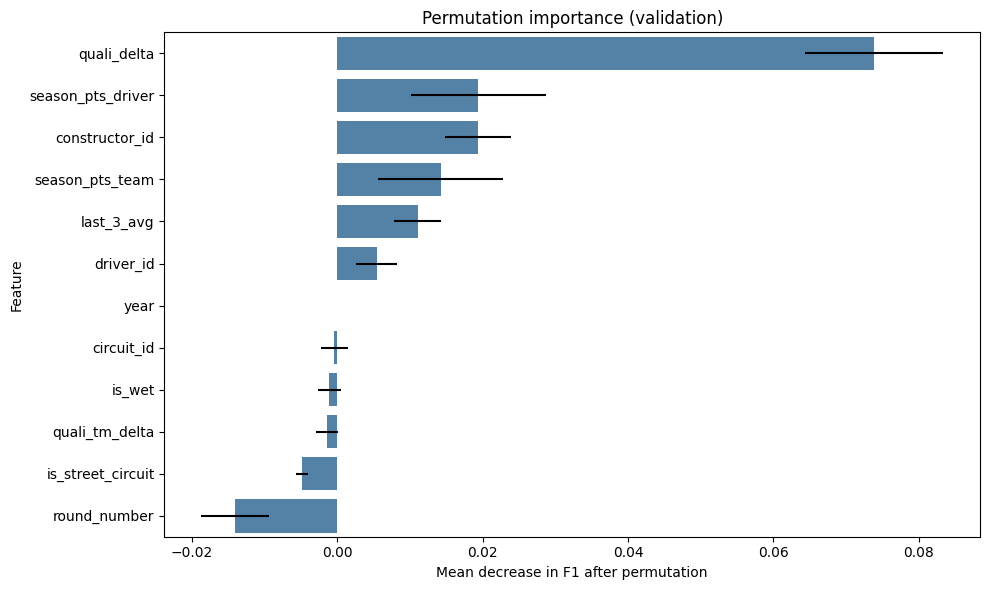

In [17]:
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

r = permutation_importance(
    clf,
    X_val,
    y_val,
    n_repeats=5,
    random_state=42,
    scoring="f1",
    n_jobs=-1,
)

perm_importance = (
    pd.DataFrame({
        "feature": X_val.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std,
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)
perm_importance

plt.figure(figsize=(10, 6))
sns.barplot(
    data=perm_importance,
    y="feature",
    x="importance_mean",
    xerr=perm_importance["importance_std"],
    color="steelblue",
)
plt.xlabel("Mean decrease in F1 after permutation")
plt.ylabel("Feature")
plt.title("Permutation importance (validation)")
plt.tight_layout()
plt.show()


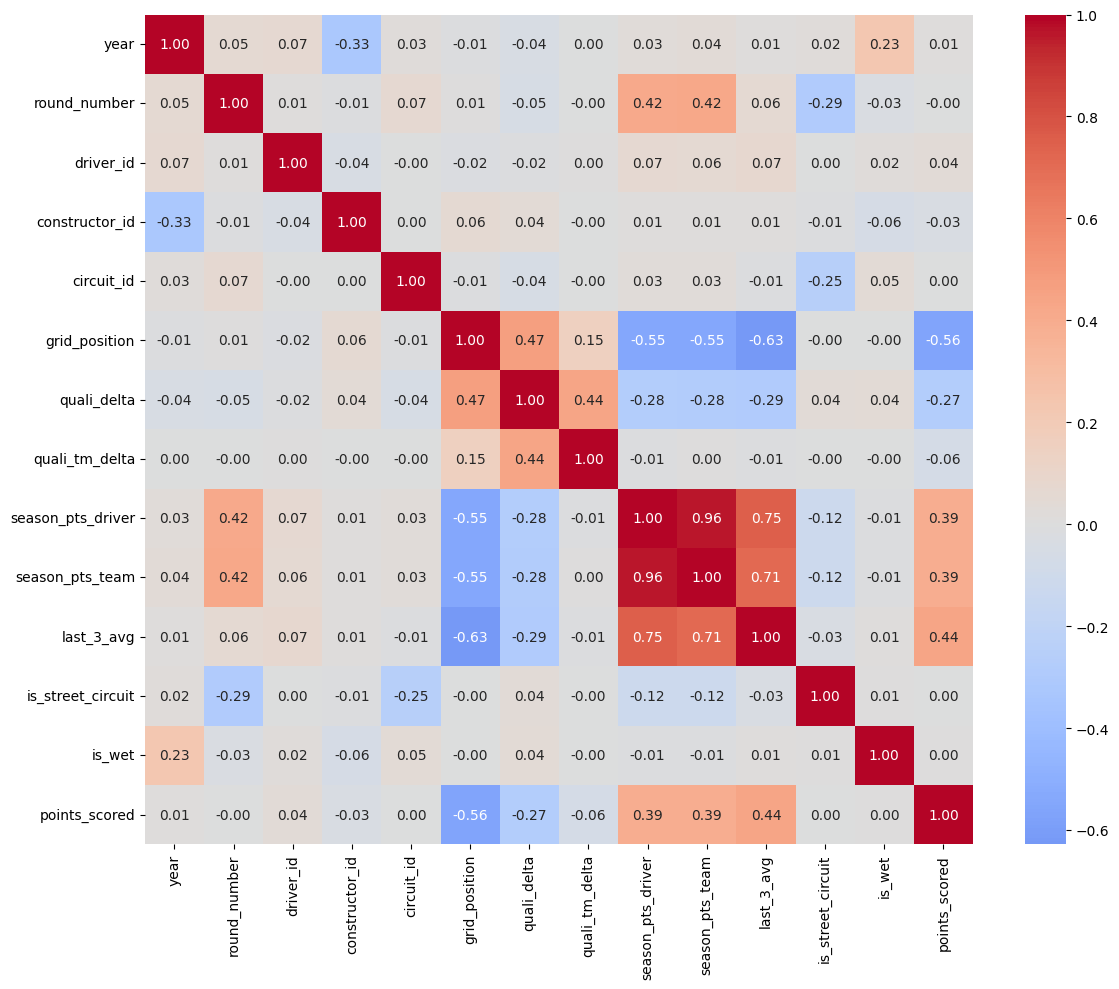

[W1218 11:58:02.429492546 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1218 11:58:03.457494783 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1218 11:58:04.435957215 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1218 11:58:05.350819306 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1218 11:58:34.227400789 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1218 11:58:35.343570074 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1218 11:58:36.416092249 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecat

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/dataset_years_train.csv")

cat_cols = ["driver_id", "constructor_id", "circuit_id", "year", "round_number"]
df_enc = df.copy()
for col in cat_cols:
    df_enc[col] = df_enc[col].astype("category").cat.codes

corr = df_enc.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.tight_layout()
plt.show()
